# Final Project
## Network Science HS19
### Imports

In [1]:
import geopandas as gpd
import fiona
import networkx as nx
import matplotlib.pyplot as plt
import random
import matplotlib.animation as animation
import numpy as np
from math import sin, cos, sqrt, atan2, radians

### Loading the data

In [40]:
#create a list of layers with in a file geodatabase 
layerlist = fiona.listlayers('./Schienennetz_LV95_20171210.gdb')
netzknoten_o = gpd.read_file('./Schienennetz_LV95_20171210.gdb',layer='Netzknoten')
netzknoten = netzknoten_o.to_crs(epsg = 4326)
netzsegment = gpd.read_file('./Schienennetz_LV95_20171210.gdb',layer='Netzsegment')

### Data Preperation

* Creating a graph based on the dataset
* Remove Nodes that are not connected to the dataset
* Print some information and draw the network

In [14]:
G = nx.Graph()
for index, row in netzknoten.iterrows():
    G.add_node(row.xtf_id, geometry = row.geometry, name = row.Betriebspunkt_Name)
    
for index, row in netzsegment.iterrows():
    G.add_edge(row.rAnfangsknoten, row.rEndknoten)

degree_sequence = [d for n, d in G.degree()]
print("Lowest degree in Network= ",min(degree_sequence))
print("Amount of Nodes in the Network",len(G.nodes()))

#Remove nodes which are not connected to any other node (degree = 0)
nodes = G.nodes()
to_delete = []
for n in nodes:
    if G.degree(n) == 0:
        to_delete.append(n)
for n in to_delete:
    
    G.remove_node(n)

degree_sequence = [d for n, d in G.degree()]
print("After removing zero degree nodes:")
print("Lowest degree in Network= ",min(degree_sequence))
print("Amount of Nodes in the Network",len(G.nodes()))

Lowest degree in Network=  0
Amount of Nodes in the Network 3190
After removing zero degree nodes:
Lowest degree in Network=  1
Amount of Nodes in the Network 3186


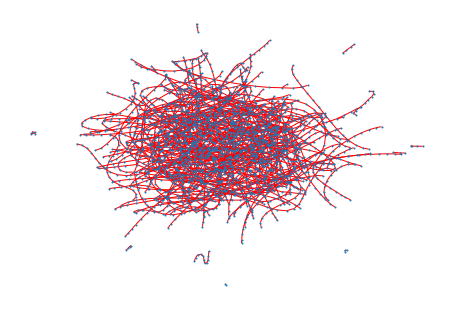

In [15]:
nx.draw(G, node_size=1, edge_color="r", with_labels = False, labels = nx.get_node_attributes(G, "name"),figsize=(10, 10))

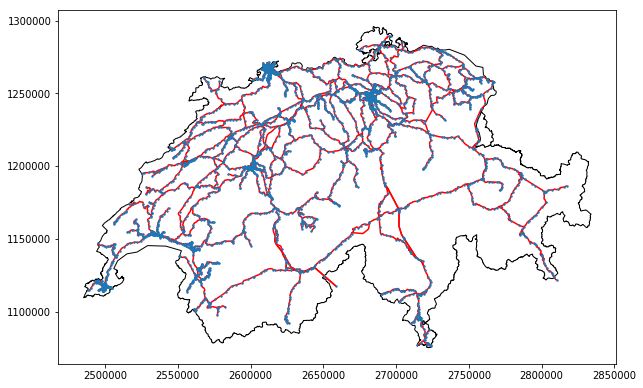

In [63]:
# Load map
map = gpd.read_file('./Maps/LV95/swissBOUNDARIES3D_1_3_TLM_LANDESGEBIET.shx')

# Create plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')

map.plot(ax=ax, color='w', edgecolor='black', zorder=0)
netzsegment.plot(ax=ax, color='r', zorder=100)
netzknoten_o.plot(ax=ax, marker='o', markersize=2, zorder=200)

plt.show()

In [16]:
#Function to calculate the distance between two coordinate points
def calculate_distance(x1,y1,x2,y2):
    # approximate radius of earth in km
    R = 6373.0
    lon1 = radians(x1)
    lat1 = radians(y1)
       
    lon2 = radians(x2)
    lat2 = radians(y2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance
    
def merge_close_nodes(G, merge_distance):
    temp = G.copy()
    node_list = temp.nodes()
    geometries = nx.get_node_attributes(G, "geometry")
    names = nx.get_node_attributes(G, "name")
    
    for node1 in node_list:
        if node1 in G.nodes():
            close_list = []
            edge_list = []
            #node1_edges = G.edges(node1)    -> (node1, node2) not in node1_edges
            for node2 in node_list:
                if node2 in G.nodes():
                    dist = calculate_distance(geometries[node1].x,geometries[node1].y, geometries[node2].x,geometries[node2].y)
                    if node1 != node2 and dist <= merge_distance and not nx.has_path(G, node1, node2):
                        close_list.append(node2)

            for merge_node in close_list:
                if G.has_node(merge_node):
                    edges = G.edges(merge_node)
                    for edge in edges:
                        edge_list.append(edge[1])
                    G.remove_node(merge_node)
                    print("removed node: ", names[merge_node])
            for to in edge_list:
                if to in G.nodes():
                    G.add_edge(node1,to)
                    print("added edge from" + names[node1] + " to " + names[to])
   
            
    
    
    

In [17]:
merge_close_nodes(G, 0.3)


removed node:  Zürich Altstetten
removed node:  Zürich Altstetten Süd (Abzw)
added edge fromZürich Altstetten, Bahnhof N to Einfang (Abzw)
added edge fromZürich Altstetten, Bahnhof N to Urdorf
added edge fromZürich Altstetten, Bahnhof N to Zürich Altstetten Ost (Abzw)
added edge fromZürich Altstetten, Bahnhof N to Zürich Mülligen
added edge fromZürich Altstetten, Bahnhof N to Zürich Herdern Abstellgruppe
added edge fromZürich Altstetten, Bahnhof N to Zürich Hauptwerkstätte
added edge fromZürich Altstetten, Bahnhof N to Zürich Altstetten Nord (Abzw)
added edge fromZürich Altstetten, Bahnhof N to Zürich Vorbahnhof West
removed node:  Bern
added edge fromBern RBS to Bern JKLM
added edge fromBern RBS to Bern Henkerbrünnli
added edge fromBern RBS to Bern Weyermannshaus (Spw)
added edge fromBern RBS to Bern Wyler
removed node:  Basel Dreispitz
removed node:  Ruchfeld
added edge fromBasel, Dreispitz Kantonsgrenze to Basel SBB Ost (Abzw)
added edge fromBasel, Dreispitz Kantonsgrenze to München

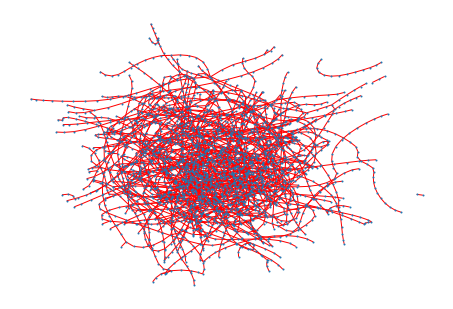

In [19]:
nx.draw(G, node_size=1, edge_color="r", with_labels = False, labels = nx.get_node_attributes(G, "name"),figsize=(10, 10))

The giant component is now 99% of all nodes. Save the giant component as an edgelist, so it can be restored without having to go through all the data preperation.

In [20]:
nx.write_edgelist(G, "Schienennetz_LV95_20171210_Connected.gml")

In [2]:
G = nx.read_edgelist("Schienennetz_LV95_20171210_Connected.gml")

### Overview of the Graph

In [128]:
#Some figures for the network: average degree <k>, global clustering coefficient C, assortativity etc.
degree_sequence = [d for n, d in G.degree()]

average_degree = sum(degree_sequence)/len(degree_sequence)
print("average degree ⟨k⟩ =",average_degree)

C = sum(nx.clustering(G).values())/len(nx.clustering(G).values())
print("global clustering C=", C)

assortativity = nx.degree_assortativity_coefficient(G)
print("assortativity=",assortativity)

print("number of connected components= ", nx.number_connected_components(G))

largest_cc = max(nx.connected_components(G), key=len)
number_largest_cc = len(largest_cc) 
number_nodes = len(G.nodes())
print("Amount of nodes in the giant component: ", number_largest_cc)
print("Relative size of the giant component to the full network =", number_largest_cc/number_nodes)
print(len(G.edges()))

average degree ⟨k⟩ = 2.130614845492195
global clustering C= 0.015755700177490572
assortativity= 0.1677628048541558
number of connected components=  5
Amount of nodes in the giant component:  3109
Relative size of the giant component to the full network = 0.9904428161834979
3344


[0, 199, 2455, 393, 72, 15, 2, 1, 0, 2]


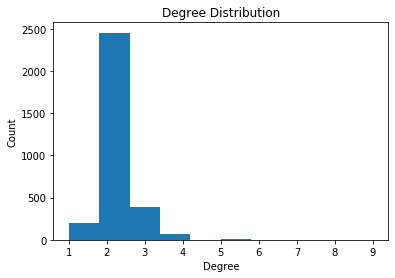

In [23]:
#Degree Distribution of the network
hist = nx.degree_histogram(G)
print(hist)
plt.title("Degree Distribution")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.hist(degree_sequence, bins = len(hist))
                     
plt.show()

In [24]:
#Centralities  (Do we need the correlations between them??)
degree = nx.degree_centrality(G)
max_degree = max(degree.values())
closeness = nx.closeness_centrality(G)
max_closeness = max(closeness.values())
betweenness = nx.betweenness_centrality(G)
max_betweenness = max(betweenness.values())
eigenvector = nx.eigenvector_centrality(G)
max_eigenvector = max(eigenvector.values())

print("Degree with maximum degree centrality: " + str([(k, v) for k, v in degree.items() if v == max_degree]))
print("Degree with maximum closeness centrality: " + str([(k, v) for k, v in closeness.items() if v == max_closeness]))
print("Degree with maximum betweenness centrality: " + str([(k, v) for k, v in betweenness.items() if v == max_betweenness]))
print("Degree with maximum eigenvector centrality: " + str([(k, v) for k, v in eigenvector.items() if v == max_eigenvector]))

Degree with maximum degree centrality: [('ch14uvag00092998', 0.0028680688336520073), ('ch14uvag00090200', 0.0028680688336520073)]
Degree with maximum closeness centrality: [('ch14uvag00089666', 0.02110106596987562)]
Degree with maximum betweenness centrality: [('ch14uvag00090093', 0.4049009479067377)]
Degree with maximum eigenvector centrality: [('ch14uvag00090200', 0.43077423413355875)]


### Random and targeted attacks on Railway network

In [26]:
def random_attacks(G):
    temp = G.copy()
    connected_component_sizes = []
    number_connected_components = []
    while nx.number_of_nodes(temp) > 1:
        node_list = []
        for n in temp.nodes():
            node_list.append(n)
        to_delete = random.choice(node_list)
        temp.remove_node(to_delete)
        
        largest_cc = len(max(nx.connected_components(temp), key=len))
        connected_component_sizes.append(largest_cc)
        number_cc = nx.number_connected_components(temp)
        number_connected_components.append(number_cc)
        
    plt.plot(range(len(connected_component_sizes)),connected_component_sizes)
    plt.title("Random attacks")
    plt.ylabel("Size of Giant component")
    plt.xlabel("Number of removed Nodes")
    plt.show()
    
    plt.plot(range(len(number_connected_components)),number_connected_components)
    plt.title("Random attacks")
    plt.ylabel("Number of connected components")
    plt.xlabel("Number of removed Nodes")
    plt.show()
       
def targeted_attacks(G, priority, priority_type):
    temp = G.copy()
    connected_component_sizes = []
    number_connected_components = []
    sorted_node_degrees = sorted(temp.nodes(), key=lambda n: priority[n])
    while nx.number_of_nodes(temp) > 1:
        temp.remove_node(sorted_node_degrees.pop())
        largest_cc = len(max(nx.connected_components(temp), key=len))
        connected_component_sizes.append(largest_cc)
        number_cc = nx.number_connected_components(temp)
        number_connected_components.append(number_cc)
    
    plt.plot(range(len(connected_component_sizes)),connected_component_sizes)
    plt.title("Targeted attacks based on " + priority_type)
    plt.ylabel("Size of Giant component")
    plt.xlabel("Number of removed Nodes")
    plt.show()
    
    plt.plot(range(len(number_connected_components)),number_connected_components)
    plt.title("Targeted attacks based on " + priority_type)
    plt.ylabel("Number of connected components")
    plt.xlabel("Number of removed Nodes")
    plt.show()

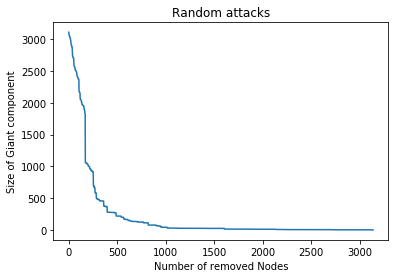

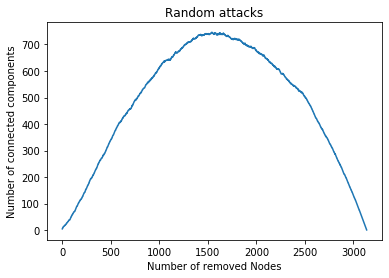

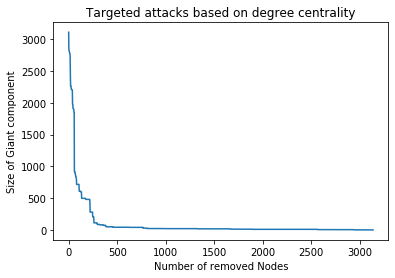

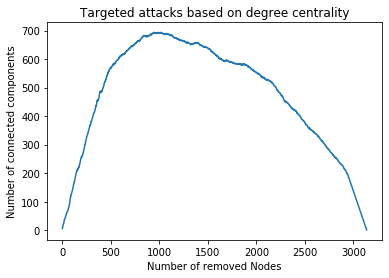

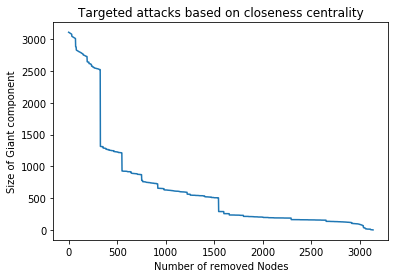

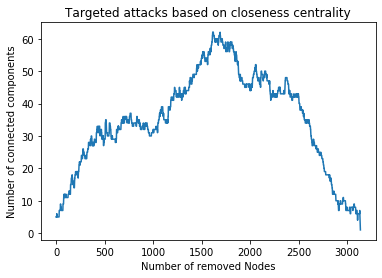

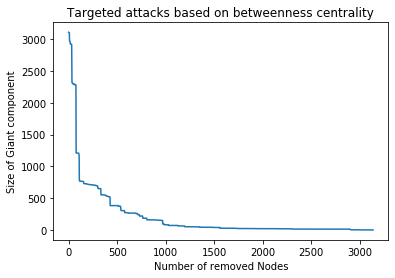

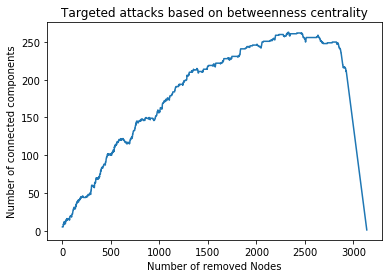

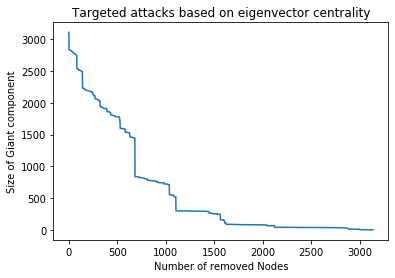

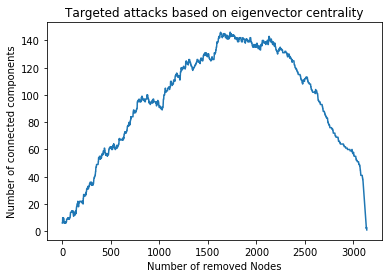

In [27]:
# Random attack
random_attacks(G)

targeted_attacks(G, degree, "degree centrality")
targeted_attacks(G, closeness , "closeness centrality")
targeted_attacks(G, betweenness, "betweenness centrality")
targeted_attacks(G, eigenvector, "eigenvector centrality")

In [20]:
def random_edge_attack(G):
    temp = G.copy()
    connected_component_sizes = []
    number_connected_components = []
    while nx.number_of_edges(temp) > 1:
        edge_list = []
        for n in temp.edges():
            edge_list.append(n)
        to_delete = random.choice(edge_list)
        temp.remove_edge(to_delete[0], to_delete[1])
        largest_cc = len(max(nx.connected_components(temp), key=len))
        connected_component_sizes.append(largest_cc)
        number_cc = nx.number_connected_components(temp)
        number_connected_components.append(number_cc)
        
    plt.plot(range(len(connected_component_sizes)),connected_component_sizes)
    plt.title("Random edge attack")
    plt.ylabel("Size of Giant component")
    plt.xlabel("Number of removed Edges")
    plt.show()

    plt.plot(range(len(number_connected_components)),number_connected_components)
    plt.title("Random edge attack")
    plt.ylabel("Number of connected components")
    plt.xlabel("Number of removed Edges")
    plt.show()
        
def targeted_edge_attack(G):
    temp = G.copy()
    connected_component_sizes = []
    number_connected_components = []
    priority = nx.edge_betweenness_centrality(temp)
    sorted_edges = sorted(temp.edges(), key=lambda n: priority[n])
    while nx.number_of_edges(temp) > 1:
        temp.remove_edge(sorted_edges[-1][0], sorted_edges[-1][1])
        sorted_edges.pop()
        largest_cc = len(max(nx.connected_components(temp), key=len))
        connected_component_sizes.append(largest_cc)
        number_cc = nx.number_connected_components(temp)
        number_connected_components.append(number_cc)
    
    plt.plot(range(len(connected_component_sizes)),connected_component_sizes)
    plt.title("Targeted edge attack based on edge betweenness centrality")
    plt.ylabel("Size of Giant component")
    plt.xlabel("Number of removed Edges")
    plt.show()

    plt.plot(range(len(number_connected_components)),number_connected_components)
    plt.title("Targeted edge attack based on edge betweenness centrality")
    plt.ylabel("Number of connected components")
    plt.xlabel("Number of removed Edges")
    plt.show()

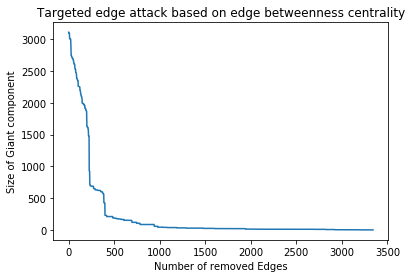

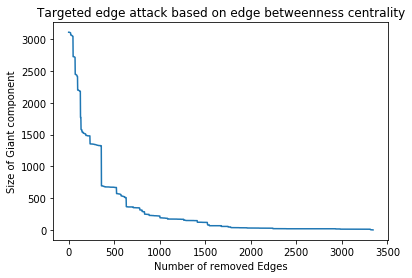

In [70]:
random_edge_attack(G)
targeted_edge_attack(G)

### Random and Targeted Attacks on a random Erdös-Renyi Graph

global clustering C= 0.0003822873526600828


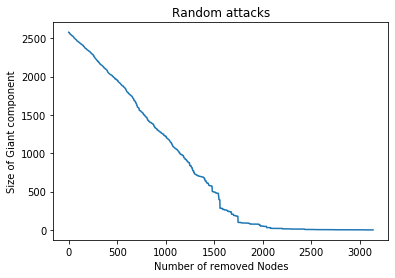

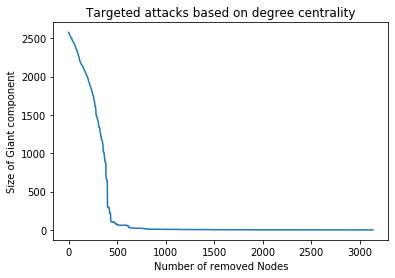

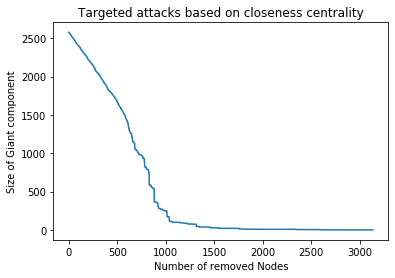

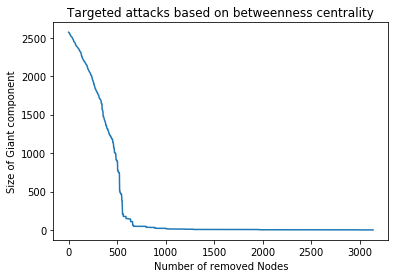

In [13]:
N = len(G.nodes())
p = average_degree/N
ER_graph = nx.gnp_random_graph(N,p)

C = sum(nx.clustering(ER_graph).values())/len(nx.clustering(ER_graph).values())
print("global clustering C=", C)

degree_ER = nx.degree_centrality(ER_graph)
closeness_ER = nx.closeness_centrality(ER_graph)
betweenness_ER = nx.betweenness_centrality(ER_graph)
#eigenvector_ER = nx.eigenvector_centrality(ER_graph)


random_attacks(ER_graph)

targeted_attacks(ER_graph, degree_ER, "degree centrality")
targeted_attacks(ER_graph, closeness_ER , "closeness centrality")
targeted_attacks(ER_graph, betweenness_ER, "betweenness centrality")
#targeted_attacks(ER_graph, eigenvector_ER, "eigenvector centrality")

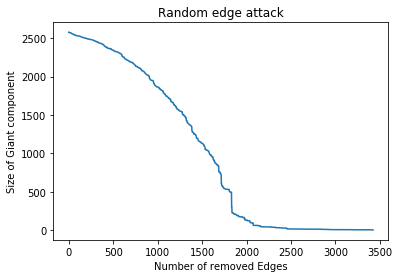

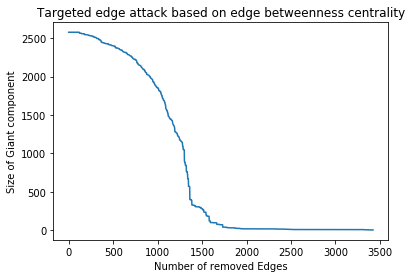

In [14]:
random_edge_attack(ER_graph)
targeted_edge_attack(ER_graph)

### Random and Targeted Attacks on a random Barabasi-Albert Graph

global clustering C= 0.012929715431906708


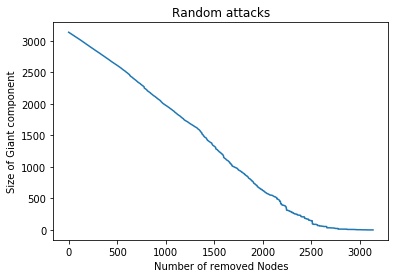

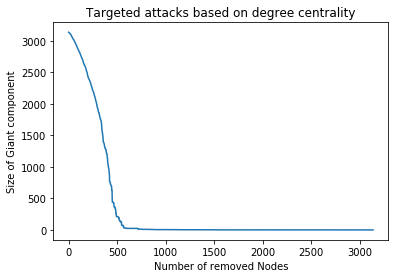

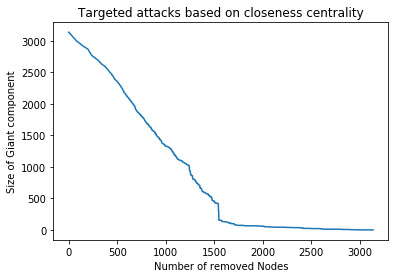

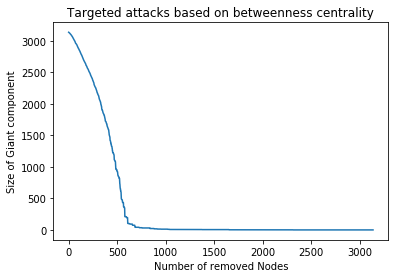

In [16]:
N = len(G.nodes())
BA_graph = nx.barabasi_albert_graph(N,2)

C = sum(nx.clustering(BA_graph).values())/len(nx.clustering(BA_graph).values())
print("global clustering C=", C)

degree_BA = nx.degree_centrality(BA_graph)
closeness_BA = nx.closeness_centrality(BA_graph)
betweenness_BA = nx.betweenness_centrality(BA_graph)
#eigenvector_BA = nx.eigenvector_centrality(BA_graph)


random_attacks(BA_graph)

targeted_attacks(BA_graph, degree_BA, "degree centrality")
targeted_attacks(BA_graph, closeness_BA , "closeness centrality")
targeted_attacks(BA_graph, betweenness_BA, "betweenness centrality")
#targeted_attacks(ER_graph, eigenvector_BA, "eigenvector centrality")

### Function to Show Giant component of the Network on Map after attacks 

In [121]:
def map_random_attacks(G, number_of_attacks=50, giant_cc = False):
    temp = G.copy()
    count = 0
    while count <= number_of_attacks:
        count += 1
        node_list = []
        for n in temp.nodes():
            node_list.append(n)
        to_delete = random.choice(node_list)
        temp.remove_node(to_delete)
    if giant_cc == True:
    
        geometries = nx.get_node_attributes(temp, "geometry")
        largest_cc = max(nx.connected_components(temp), key=len)
        Giant_component = nx.Graph()
        netzsegment = gpd.read_file('./Schienennetz_LV03_20171210.gdb',layer='Netzsegment')
        for n in largest_cc:
            Giant_component.add_node(n,geometry = geometries[n], name = names[n])
        for index, row in netzsegment.iterrows():
            if (row.rAnfangsknoten, row.rEndknoten) in list(temp.edges()) or (row.rEndknoten, row.rAnfangsknoten) in list(temp.edges()):
                if row.rAnfangsknoten in largest_cc and row.rEndknoten in largest_cc:
                    Giant_component.add_edge(row.rAnfangsknoten, row.rEndknoten)

        geometries = nx.get_node_attributes(Giant_component, "geometry")
        for key in geometries:
            geometries[key] = [float(geometries[key].x),float(geometries[key].y)]
        map = gpd.read_file('./Maps/swissBOUNDARIES3D_1_3_TLM_LANDESGEBIET.shx')
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_aspect('equal')
        map.plot(ax=ax, color='w', edgecolor='black', zorder=0)
        nx.draw_networkx(Giant_component,pos = geometries ,with_labels= False, node_size = 2, edge_color = "r", labels = nx.get_node_attributes(G, "name"))
    else:
        largest_cc = max(nx.connected_components(temp), key=len)
        color = []
        for n in temp.nodes():
            if n in largest_cc:
                color.append("b")
            else:
                color.append("k")
        geometries = nx.get_node_attributes(temp, "geometry")
        for key in geometries:
            geometries[key] = [float(geometries[key].x),float(geometries[key].y)]
        map = gpd.read_file('./Maps/swissBOUNDARIES3D_1_3_TLM_LANDESGEBIET.shx')
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_aspect('equal')
        map.plot(ax=ax, color='w', edgecolor='black', zorder=0)
        nx.draw_networkx(temp,pos = geometries ,with_labels= False, node_size = 2, edge_color = "r", labels = nx.get_node_attributes(G, "name"), node_color = color)
            
def map_targeted_attacks(G, priority, priority_type,number_of_attacks = 50, giant_cc = False):
    temp = G.copy()
    count = 0
    sorted_node_degrees = sorted(temp.nodes(), key=lambda n: priority[n])
    #print(len(sorted_node_degrees))
    while count <= number_of_attacks:
        count += 1
        temp.remove_node(sorted_node_degrees.pop())
    if giant_cc == True:
        geometries = nx.get_node_attributes(temp, "geometry")
        largest_cc = max(nx.connected_components(temp), key=len)
        Giant_component = nx.Graph()
        netzsegment = gpd.read_file('./Schienennetz_LV03_20171210.gdb',layer='Netzsegment')

        for n in largest_cc:
            Giant_component.add_node(n,geometry = geometries[n], name = names[n])
        for index, row in netzsegment.iterrows():
            if (row.rAnfangsknoten, row.rEndknoten) in list(temp.edges()) or (row.rEndknoten, row.rAnfangsknoten) in list(temp.edges()):
                if row.rAnfangsknoten in largest_cc and row.rEndknoten in largest_cc:
                    Giant_component.add_edge(row.rAnfangsknoten, row.rEndknoten)    


        geometries = nx.get_node_attributes(Giant_component, "geometry")
        for key in geometries:
            geometries[key] = [float(geometries[key].x),float(geometries[key].y)]
        map = gpd.read_file('./Maps/swissBOUNDARIES3D_1_3_TLM_LANDESGEBIET.shx')
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_aspect('equal')
        map.plot(ax=ax, color='w', edgecolor='black', zorder=0)
        nx.draw_networkx(Giant_component,pos = geometries ,with_labels= False, node_size = 2, edge_color = "r", labels = nx.get_node_attributes(G, "name"))
        
    else:
        largest_cc = max(nx.connected_components(temp), key=len)
        color = []
        for n in temp.nodes():
            if n in largest_cc:
                color.append("b")
            else:
                color.append("k")
        geometries = nx.get_node_attributes(temp, "geometry")
        for key in geometries:
            geometries[key] = [float(geometries[key].x),float(geometries[key].y)]
        map = gpd.read_file('./Maps/swissBOUNDARIES3D_1_3_TLM_LANDESGEBIET.shx')
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_aspect('equal')
        map.plot(ax=ax, color='w', edgecolor='black', zorder=0)
        nx.draw_networkx(temp,pos = geometries ,with_labels= False, node_size = 2, edge_color = "r", labels = nx.get_node_attributes(G, "name"), node_color = color)

In [80]:
#create a list of layers with in a file geodatabase 
layerlist = fiona.listlayers('./Schienennetz_LV03_20171210.gdb')
netzknoten = gpd.read_file('./Schienennetz_LV03_20171210.gdb',layer='Netzknoten')
netzsegment = gpd.read_file('./Schienennetz_LV03_20171210.gdb',layer='Netzsegment')


new_G = nx.Graph()
for index, row in netzknoten.iterrows():
    if row.xtf_id in list(G.nodes().keys()):
        new_G.add_node(row.xtf_id, geometry = row.geometry, name = row.Betriebspunkt_Name)
    
for index, row in netzsegment.iterrows():
    if (row.rAnfangsknoten, row.rEndknoten) in list(G.edges()) or (row.rEndknoten, row.rAnfangsknoten) in list(G.edges()): 
        new_G.add_edge(row.rAnfangsknoten, row.rEndknoten)




Lowest degree in Network=  0
Amount of Nodes in the Network 3139


In [107]:
new_G = G
for index, row in netzknoten.iterrows():
    if row.xtf_id in list(G2.nodes().keys()):
        G2.nodes[row.xtf_id]["geometry"] = row.geometry
        
        
degree_sequence = [d for n, d in new_G.degree()]
print("Lowest degree in Network= ",min(degree_sequence))
print("Amount of Nodes in the Network",len(new_G.nodes()))    

Lowest degree in Network=  1
Amount of Nodes in the Network 3139


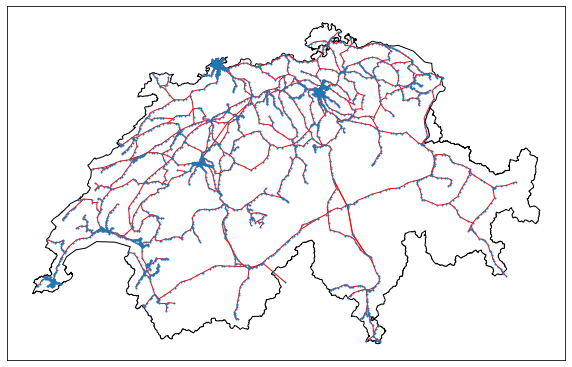

In [125]:
geometries = nx.get_node_attributes(new_G, "geometry")
for key in geometries:
    geometries[key] = [float(geometries[key].x),float(geometries[key].y)]
map = gpd.read_file('./Maps/swissBOUNDARIES3D_1_3_TLM_LANDESGEBIET.shx')
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')
map.plot(ax=ax, color='w', edgecolor='black', zorder=0)
nx.draw_networkx(new_G,pos = geometries ,with_labels= False, node_size = 1, edge_color = "r", labels = nx.get_node_attributes(G, "name"))

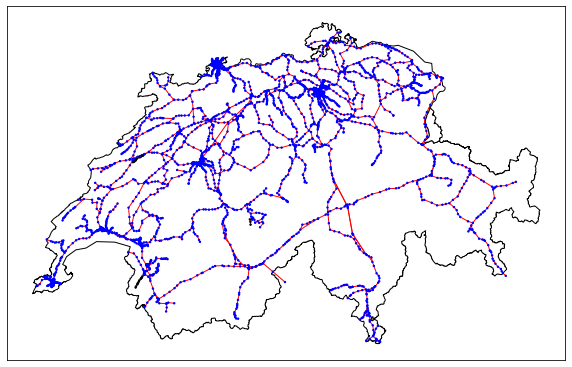

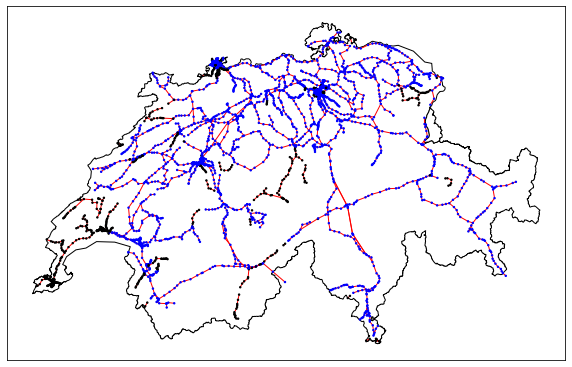

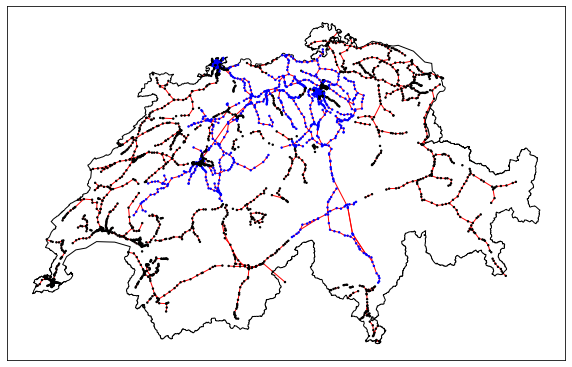

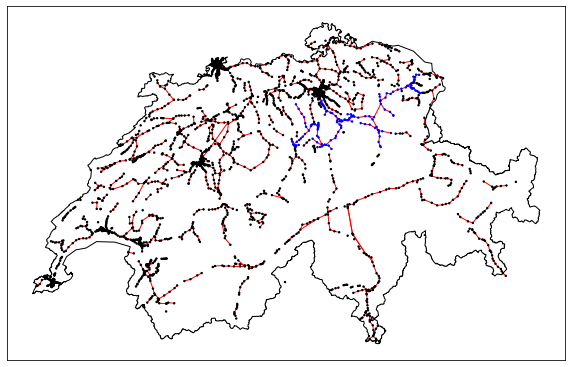

In [120]:

map_random_attacks(new_G, 0, giant_cc = False)
map_random_attacks(new_G,100, giant_cc = False)
map_random_attacks(new_G,250, giant_cc = False)
map_random_attacks(new_G,500, giant_cc = False)

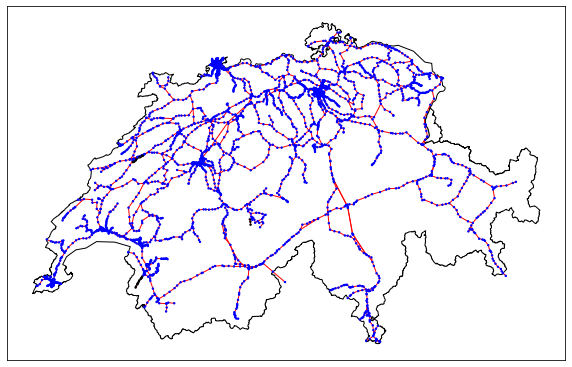

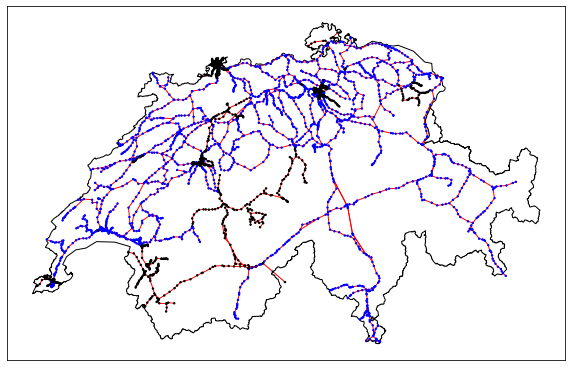

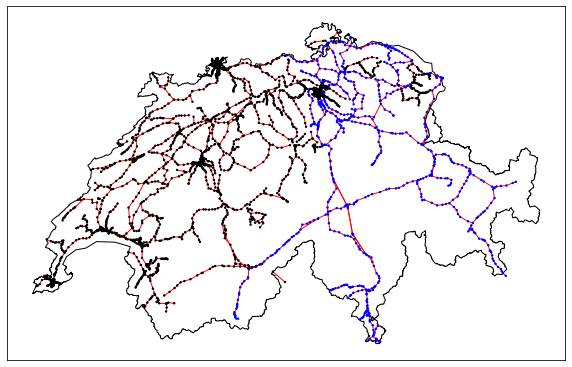

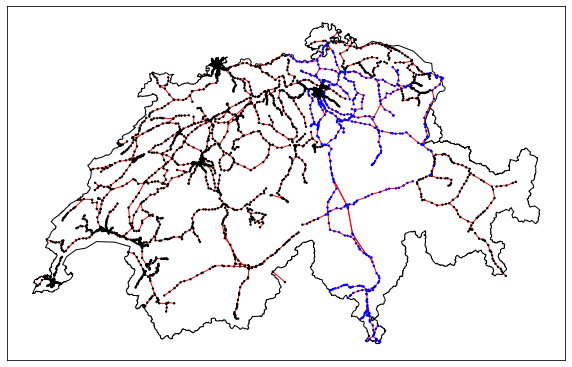

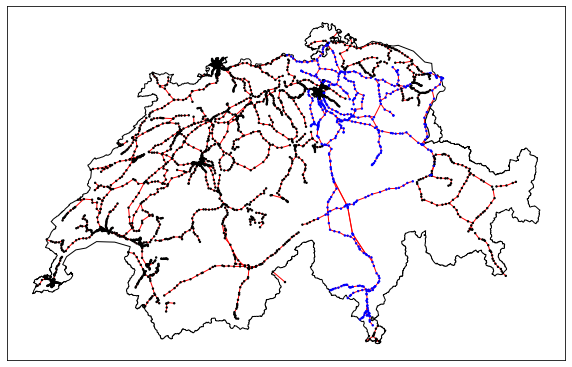

In [122]:
degree_newG= nx.degree_centrality(new_G)
map_targeted_attacks(new_G, degree_newG, "degree centrality", 0, giant_cc = False)
map_targeted_attacks(new_G, degree_newG, "degree centrality", 50, giant_cc = False)
map_targeted_attacks(new_G, degree_newG, "degree centrality", 100, giant_cc = False)
map_targeted_attacks(new_G, degree_newG, "degree centrality", 150, giant_cc = False)
map_targeted_attacks(new_G, degree_newG, "degree centrality", 200, giant_cc = False)

### TODO
Code:

Compare to ER or BA
Targeted attacks on edges (metrics?)
Compared to avg shortest paths, nr of connected components

Show map after attacks (animation?)
